# AirBnB Seattle Project

This project is part of the Udacity's Data Science Nanodegree program where I have chosen to write a blog post using AirBnB's Seattle Open Data.

The CRISP-DM (Cross Industry Process for Data Mining) process serves as a guide for the project and is as follows:

* Business Understanding
* Data Understanding
* Data Preparation
* Modeling
* Evaluation
* Deploy

# Business Understanding
By exploring the AirBnB Seattle data, I hope to gain more understanding on the Seattle rental market, specifically, questions regarding:
 * What property features determine the listing price?
 * What property features determine the its popularity? (with reviews per month as proxy)
 * When is the most popular month to rent in Seattle?

# Data Understanding

In [1]:
# Import libraries
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import helper_functions as helper

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
csvs = glob.glob('./input/seattle/*.csv')
csvs

['./input/seattle\\calendar.csv',
 './input/seattle\\listings.csv',
 './input/seattle\\reviews.csv']

In [3]:
# Listings
base = pd.read_csv(csvs[1])
listings_df = base.copy()
listings_df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


#### Features that are available for analysis: Including Non-Null count and Datatypes

In [4]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

# Data Preparation
A preliminary investigation reveals that further data cleansing and preprocessing is needed before it can be used as an input for our project pipeline. 

The steps that needed to be undertaken are as per follows:
 * Removing Unary and URL features except for 'thumbnail_url'.
 * Removing features with many missing values : >= 21% missing.
 * Removing irrelevant features that lacks business justification or are too granular.
     * Text fields except for 'description'.
     * Fields with redundant information like 30,60,90 day availability, retain only availability_365.
     * Similarly with weekly, monthly price, retain only 'price' field.
     * The detailed split of review scores except the final rating.
     * More granular aspects of location.
 * Remove special characters like '$' and ',' from price features.
 * Remove '%' character from percentage features.
 * Convert thumnail data as available or not-available.
 * Convert host since from date to number of days.
 * Convert amenities column to number of amenities.
 * Impute Null as Zero for security deposit and cleaning fees.
 * Count number of amenities from list.

####  Features that are Unary and URL

In [5]:
unary_columns, url_columns = [], []

for i in listings_df.columns:
    if len(listings_df[i].unique())==1:
        print('Unary Column: ',i , listings_df[i].unique())
        unary_columns.append(i)
    if 'url' in i:
        url_columns = url_columns+[i]

Unary Column:  scrape_id [20160104002432]
Unary Column:  last_scraped ['2016-01-04']
Unary Column:  experiences_offered ['none']
Unary Column:  market ['Seattle']
Unary Column:  country_code ['US']
Unary Column:  country ['United States']
Unary Column:  has_availability ['t']
Unary Column:  calendar_last_scraped ['2016-01-04']
Unary Column:  requires_license ['f']
Unary Column:  license [nan]
Unary Column:  jurisdiction_names ['WASHINGTON']


In [6]:
url_columns

['listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

In [7]:
# Drop all URL variables but convert [thumbnail_url] into binary 
listings_df[url_columns].isnull().sum()/len(listings_df)

listing_url           0.000000
thumbnail_url         0.083814
medium_url            0.083814
picture_url           0.000000
xl_picture_url        0.083814
host_url              0.000000
host_thumbnail_url    0.000524
host_picture_url      0.000524
dtype: float64

In [8]:
url_columns = list(set(url_columns) - {'thumbnail_url'})

####  Features that are Unary and URL Features with Many Missing Values

In [9]:
percent_missing = listings_df.isnull().sum() * 100 / len(listings_df)
missing_value_df = pd.DataFrame({   'column_name': listings_df.columns,
                                    'percent_missing': round(percent_missing,2)})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=[False])
missing_value_df.reset_index(drop=True)

,column_name,percent_missing
0,license,100.00
1,square_feet,97.46
2,monthly_price,60.27
3,security_deposit,51.13
4,weekly_price,47.38
5,notes,42.06
6,neighborhood_overview,27.03
7,cleaning_fee,26.98
8,transit,24.46
9,host_about,22.50


In [10]:
missing_value_df = missing_value_df[missing_value_df['percent_missing']>=21.00].reset_index(drop=True)
missing_value_df

,column_name,percent_missing
0,license,100.00
1,square_feet,97.46
2,monthly_price,60.27
3,security_deposit,51.13
4,weekly_price,47.38
5,notes,42.06
6,neighborhood_overview,27.03
7,cleaning_fee,26.98
8,transit,24.46
9,host_about,22.50


#### Impute NULL to be ZERO for security deposit and cleaning fee

In [11]:
# Assume NULL to be ZERO in security_deposit, cleaning_fee
missing_columns = missing_value_df['column_name'].values.tolist() 
missing_columns = list(set(missing_columns) - {'security_deposit','cleaning_fee'})
missing_columns

['license',
 'weekly_price',
 'monthly_price',
 'notes',
 'square_feet',
 'host_about',
 'transit',
 'neighborhood_overview']

#### Removing Features that are obviously irrelevant (as described above)

In [12]:
irrelevant_columns = [   'id'
                        ,'name'
                        ,'summary'
                        ,'space'
                        ,'host_id'
                        ,'host_name'
                        ,'host_location'
                        ,'host_neighbourhood'
                        ,'host_listings_count'
                        ,'host_total_listings_count'
                        ,'host_verifications'
                        ,'street'
                        ,'neighbourhood'
                        ,'neighbourhood_cleansed'
                        ,'city'
                        ,'state'
                        ,'zipcode'
                        ,'smart_location'
                        ,'latitude'
                        ,'longitude'
                        ,'is_location_exact'
                        ,'minimum_nights'
                        ,'maximum_nights'
                        ,'calendar_updated'
                        ,'availability_30'
                        ,'availability_60'
                        ,'availability_90'
                        ,'first_review'
                        ,'last_review'
                        ,'require_guest_profile_picture'
                        ,'require_guest_phone_verification'
                        ,'calculated_host_listings_count']

####  Features that are Unary and URL Consolidate List of Features that are to be removed

In [13]:
remove_columns = unary_columns + url_columns + missing_columns + irrelevant_columns
remove_columns

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'license',
 'jurisdiction_names',
 'xl_picture_url',
 'listing_url',
 'host_url',
 'picture_url',
 'medium_url',
 'host_thumbnail_url',
 'host_picture_url',
 'license',
 'weekly_price',
 'monthly_price',
 'notes',
 'square_feet',
 'host_about',
 'transit',
 'neighborhood_overview',
 'id',
 'name',
 'summary',
 'space',
 'host_id',
 'host_name',
 'host_location',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'smart_location',
 'latitude',
 'longitude',
 'is_location_exact',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'availability_30',
 'availability_60',
 'availability_90',
 'first_review',
 'last_review',
 'require_guest_profile_picture',
 'require_guest_phone_verifica

In [14]:
listings_df.drop(listings_df[remove_columns], axis=1, inplace=True)

In [15]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   description                   3818 non-null   object 
 1   thumbnail_url                 3498 non-null   object 
 2   host_since                    3816 non-null   object 
 3   host_response_time            3295 non-null   object 
 4   host_response_rate            3295 non-null   object 
 5   host_acceptance_rate          3045 non-null   object 
 6   host_is_superhost             3816 non-null   object 
 7   host_has_profile_pic          3816 non-null   object 
 8   host_identity_verified        3816 non-null   object 
 9   neighbourhood_group_cleansed  3818 non-null   object 
 10  property_type                 3817 non-null   object 
 11  room_type                     3818 non-null   object 
 12  accommodates                  3818 non-null   int64  
 13  bat

#### Invoke Helper functions to further clean the dataframe

In [16]:
seattle_df = helper.clean_data(listings_df)

# Data Preprocessing: Price
Based on the questions above two different set of features were required to carry out the analysis.

 * Keep remaining features except property text description for predicting price.
 * Use property text description alone for price prediction.

In [17]:
seattle_df.drop('description', axis=1, inplace=True)
seattle_df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,has_thumbnail_url,total_amenities
0,1607.0,within a few hours,96.0,100.0,0,1,1,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0.0,0.0,2,5.0,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,4.07,0,10
1,1047.0,within an hour,98.0,100.0,1,1,1,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,100.0,40.0,1,0.0,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,1.48,1,16
2,571.0,within a few hours,67.0,100.0,0,1,1,Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0,1000.0,300.0,10,25.0,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,1.15,0,21
3,789.0,NaN,NaN,NaN,0,1,1,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,100.0,0.0,0.0,1,0.0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,14
4,1497.0,within an hour,100.0,NaN,0,1,1,Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450.0,700.0,125.0,6,15.0,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,0,0.89,0,13


In [18]:
seattle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_since                    3816 non-null   float64
 1   host_response_time            3295 non-null   object 
 2   host_response_rate            3295 non-null   float64
 3   host_acceptance_rate          3045 non-null   float64
 4   host_is_superhost             3818 non-null   int64  
 5   host_has_profile_pic          3818 non-null   int64  
 6   host_identity_verified        3818 non-null   int64  
 7   neighbourhood_group_cleansed  3818 non-null   object 
 8   property_type                 3817 non-null   object 
 9   room_type                     3818 non-null   object 
 10  accommodates                  3818 non-null   int64  
 11  bathrooms                     3802 non-null   float64
 12  bedrooms                      3812 non-null   float64
 13  bed

#### Splitting Data into Features/Label and Dividing Label/Price feature into (High,Low)=(1,0)

In [19]:
label_df   = np.where(seattle_df['price'] > seattle_df['price'].median(), 0, 1)
feature_df = seattle_df.drop(['price'], axis=1)

#### Impute Missing Categorical Values with 'Most Frequent' and Apply Min-Max Feature Scaling

In [20]:
scaled_df = helper.process_features(feature_df)

In [21]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 73 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   host_since                                        3818 non-null   float64
 1   host_response_rate                                3818 non-null   float64
 2   host_acceptance_rate                              3818 non-null   float64
 3   host_is_superhost                                 3818 non-null   float64
 4   host_has_profile_pic                              3818 non-null   float64
 5   host_identity_verified                            3818 non-null   float64
 6   accommodates                                      3818 non-null   float64
 7   bathrooms                                         3818 non-null   float64
 8   bedrooms                                          3818 non-null   float64
 9   beds               

# Modeling and Evaluation: Price
### What property features determine the listing price?
AdaBoostClassifier with decision tree base estimator and optimized with GridSearchCV.

In [22]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=123)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [0.005, .01, 0.05, 0.1],
              'base_estimator__min_samples_split' : [2, 4, 6, 8], 
              'base_estimator__max_depth' : [2, 4, 6, 8]}

In [23]:
best_clf, X_train, X_test, y_train, y_test = helper.boost_classifier(clf, parameters, scaled_df, label_df)

C:\Users\tai_j\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [24]:
print(best_clf)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_split=6),
                   learning_rate=0.1, n_estimators=100, random_state=123)


In [25]:
# Unoptimized model
test_accuracy, train_accuracy = helper.prediction_scores(clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7304
Accuracy score on training data: 1.0000


In [26]:
# Optimized model
test_accuracy, train_accuracy = helper.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.8272
Accuracy score on training data: 0.8333


#### Top 10 important features

In [27]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print('Top 10 Important Features')
display(X_train.columns.values[indices[:10]])

Top 10 Important Features


array(['room_type_Entire_home_apt', 'accommodates', 'availability_365',
       'reviews_per_month', 'neighbourhood_group_cleansed_Downtown',
       'cleaning_fee', 'bedrooms', 'property_type_Bed_and_Breakfast',
       'neighbourhood_group_cleansed_Capitol_Hill', 'host_since'],
      dtype=object)

# Modeling and Evaluation: Popularity
## What property features determine its popularity? 
 * Using number of reviews per month as a proxy for popularity.
 * Similar data preparation as for previous price modeling.

In [28]:
# Remove records with Null values in 'reviews_per_month'
revpm_df         = seattle_df[seattle_df['reviews_per_month'].isnull() != True]

# Split Data into features and labels
label_revpm_df   = np.where(revpm_df['reviews_per_month'] > revpm_df['reviews_per_month'].median(), 0, 1)
feature_revpm_df = revpm_df.drop(['reviews_per_month'], axis=1)

# Feature Scaling
scaled_revpm_df  = helper.process_features(feature_revpm_df)
scaled_revpm_df.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,has_thumbnail_url,total_amenities,host_response_time_a_few_days_or_more,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon_Hill,neighbourhood_group_cleansed_Capitol_Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central_Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake_City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other_neighborhoods,neighbourhood_group_cleansed_Queen_Anne,neighbourhood_group_cleansed_Rainier_Valley,neighbourhood_group_cleansed_Seward_Park,neighbourhood_group_cleansed_University_District,neighbourhood_group_cleansed_West_Seattle,property_type_Apartment,property_type_Bed_and_Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper_RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire_home_apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull_out_Sofa,bed_type_Real_Bed
0,0.611305,0.951807,1.0,0.0,1.0,1.0,0.200000,0.1250,0.142857,0.000000,0.064417,0.00,0.000000,0.153846,0.016667,0.947945,0.435518,0.9375,1.000,1.000000,1.0,1.0,0.833333,1.000,0.0,0.0,0.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.394503,0.975904,1.0,1.0,1.0,1.0,0.200000,0.1250,0.142857,0.000000,0.130879,0.02,0.133333,0.076923,0.000000,0.797260,0.088795,0.9500,1.000,1.000000,1.0,1.0,1.000000,1.000,0.0,0.0,1.0,0.533333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.210221,0.602410,1.0,0.0,1.0,1.0,0.666667,0.5625,0.714286,0.428571,0.974438,0.20,1.000000,0.769231,0.083333,0.602740,0.040169,0.9625,1.000,1.000000,1.0,1.0,1.000000,1.000,0.0,0.0,0.0,0.700000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.568719,1.000000,1.0,0.0,1.0,1.0,0.333333,0.2500,0.428571,0.142857,0.437628,0.14,0.416667,0.461538,0.050000,1.000000,0.078224,0.9000,0.875,0.857143,1.0,1.0,0.833333,0.875,0.0,0.0,0.0,0.433333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.699961,1.000000,1.0,0.0,1.0,1.0,0.066667,0.1250,0.142857,0.000000,0.100204,0.00,0.133333,0.076923,0.100000,0.827397,0.033827,0.9375,1.000,1.000000,1.0,1.0,1.000000,1.000,0.0,0.0,1.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


AdaBoostClassifier with decision tree base estimator. The model was optimized using GridSearchCV.

In [29]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=123)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [0.005, .01, 0.05, 0.1],
              'base_estimator__min_samples_split' : [2, 4, 6, 8], 
              'base_estimator__max_depth' : [2, 4, 6, 8]}

In [30]:
best_clf, X_train, X_test, y_train, y_test = helper.boost_classifier(clf, parameters, scaled_revpm_df, label_revpm_df)

C:\Users\tai_j\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [31]:
print(best_clf)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_split=8),
                   learning_rate=0.1, n_estimators=100, random_state=123)


In [32]:
# Unoptimized model
test_accuracy, train_accuracy = helper.prediction_scores(clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7825
Accuracy score on training data: 1.0000


In [33]:
# Optimized model
test_accuracy, train_accuracy = helper.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.8607
Accuracy score on training data: 0.8687


In [34]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print('Top 10 Important Features')
display(X_train.columns.values[indices[:10]])

Top 10 Important Features


array(['number_of_reviews', 'host_since', 'availability_365',
       'cleaning_fee', 'price', 'total_amenities',
       'host_response_time_within_an_hour', 'bedrooms',
       'instant_bookable', 'host_is_superhost'], dtype=object)

# When is the most popular month to rent in Seattle?
 * Jul, Aug and Sep are the best period to maximise revenue. Before May are the best time for maintenance work Oct to Dec is a good time to take a break and enjoy the holidays.

In [35]:
# Listings Dataframe
base = pd.read_csv(csvs[1])
listings_df = base.copy()
listings_df.rename(columns={'id':'listing_id'}, inplace=True)

# Reviews Dataframe
base = pd.read_csv(csvs[2])
reviews_df = base.copy()
reviews_df = reviews_df[['id','listing_id','date']]

# Datetime Conversion
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df.head()

,id,listing_id,date
0,38917982,7202016,2015-07-19
1,39087409,7202016,2015-07-20
2,39820030,7202016,2015-07-26
3,40813543,7202016,2015-08-02
4,41986501,7202016,2015-08-10


In [45]:
# Bookings Dataframe
bookings_df = pd.merge(reviews_df, listings_df, on='listing_id')
bookings_df['estimated_revenue'] = bookings_df['price'] * bookings_df['minimum_nights']
bookings_df.head(20)

,id,listing_id,date,minimum_nights,price,estimated_revenue
0,38917982,7202016,2015-07-19,2,75.0,150.0
1,39087409,7202016,2015-07-20,2,75.0,150.0
2,39820030,7202016,2015-07-26,2,75.0,150.0
3,40813543,7202016,2015-08-02,2,75.0,150.0
4,41986501,7202016,2015-08-10,2,75.0,150.0
5,43979139,7202016,2015-08-23,2,75.0,150.0
6,45265631,7202016,2015-09-01,2,75.0,150.0
7,46749120,7202016,2015-09-13,2,75.0,150.0
8,47783346,7202016,2015-09-21,2,75.0,150.0
9,48388999,7202016,2015-09-26,2,75.0,150.0


In [49]:
# get revenue by listings
listings_df=listings_df[['listing_id','minimum_nights','price']]
listings_df['price'] = listings_df['price'].map(lambda x: helper.convert_to_price(x))

listings_df_revenue = bookings_df[['listing_id','estimated_revenue']].groupby(['listing_id']).sum()
listings_df = pd.merge(listings_df, listings_df_revenue, on='listing_id', how='left')
listings_df.at[listings_df['estimated_revenue'].isnull(), 'estimated_revenue'] = 0
listings_df

C:\Users\tai_j\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,listing_id,minimum_nights,price,estimated_revenue
0,241032,1,85.0,17595.0
1,953595,2,150.0,12900.0
2,3308979,4,975.0,78000.0
3,7421966,1,100.0,0.0
4,278830,1,450.0,17100.0
...,...,...,...,...
3813,8101950,3,359.0,1077.0
3814,8902327,2,79.0,316.0
3815,10267360,1,93.0,0.0
3816,9604740,3,99.0,0.0


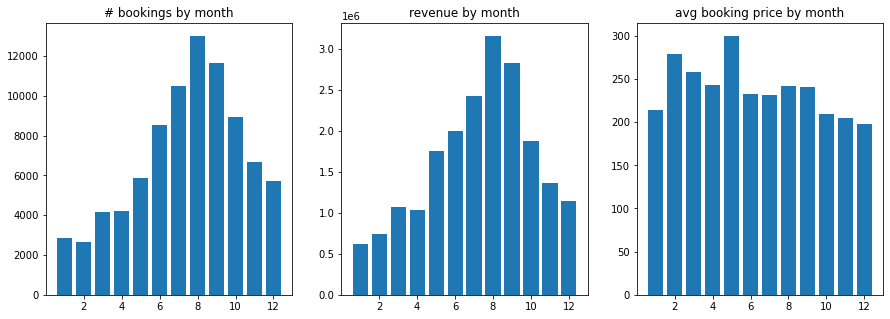

In [50]:
plt.figure(figsize=(15, 5))

# # bookings by month
plotdata1 = reviews_df[['date']].groupby(reviews_df["date"].dt.month).count()
plotdata1.rename(columns={'date':'# of bookings'}, inplace=True)

ax = plt.subplot(1, 3, 1)
ax.set_title("# bookings by month")
plt.bar(plotdata1.index, plotdata1['# of bookings'])

# revenue by month
plotdata2 = bookings_df[['date','estimated_revenue']].groupby(bookings_df["date"].dt.month).sum()
plotdata2.rename(columns={'estimated_revenue':'revenue'}, inplace=True)

ax = plt.subplot(1, 3, 2)
ax.set_title("revenue by month")
plt.bar(plotdata2.index, plotdata2['revenue'])

# avg booking price by month
plotdata3 = pd.concat([plotdata1, plotdata2], axis=1)
plotdata3['avg booking price'] = plotdata3['revenue'] / plotdata3['# of bookings']
plotdata3.head()

ax = plt.subplot(1, 3, 3)
ax.set_title("avg booking price by month")
plt.bar(plotdata3.index, plotdata3['avg booking price'])

_ = plt.plot()

# Conclusion
This simple and straightforward data-driven investigation of the Seattle Airbnb market has provided us with insights may be helpful to anything keen to be involved in the property rental business. 

A data-driven strategy would be important for any potential Airbnb host to get the important things right, and to fine-tune their existing listings to obtain higher premiums for their listing prices. 

As per our investigation, there are factors that Airbnb hosts can tune: like (1) setting optimal prices/cleaning fees, (2) quick to reply, and (3) making the lodging available for more days of the year, and to some extent: (4) more amenities (perhaps adding on wifi, free breakfast, etc).

And there are factors that will be more relevant to people who are investing in a property or who have the resources to modify their lodgings, like: (1) making sure the property is situated in Downtown/Capitol Hill, (2) more rooms, (3) making whole apartments available instead of single-rooms, (4) enlarging the unit to accommodate more.

Understanding all these factors in depth will definitely provide an edge to anyone competing in the property rental market.